# Landsat EVI/NDVI Change Detection with H3 Aggregation

Streaming approach for memory-efficient processing of large raster datasets.

**Vegetation Indices:**
- **EVI** (Enhanced Vegetation Index): Optimized for high biomass regions and reduces atmospheric influences
- **NDVI** (Normalized Difference Vegetation Index): Classic vegetation index using red and near-infrared bands

**Case Study: Chernobyl Exclusion Zone**

The 1986 Chernobyl disaster was catastrophic—the worst nuclear accident in history. Yet in the decades since evacuation, the Exclusion Zone has become an unintentional experiment in what happens when humans withdraw from a landscape. This notebook uses satellite imagery to examine one aspect of that story: vegetation change between the early 1990s and 2020s.

Inspired by [Cal Flyn](https://www.calflyn.com/)'s *Islands of Abandonment*, which includes her trip to Chernobyl and Pripyat before the war.

---

## Running this notebook

Install [uv](https://docs.astral.sh/uv/) and run:


`uvx juv run landsat_vegetation_change_h3.ipynb`

Dependencies are declared inline (PEP 723) and install automatically.

---

**Key design:**
- Process one time period at a time → aggregate to H3 → discard raster
- Controlled concurrency (default 2) - never holds many rasters in memory
- DuckDB H3 extension for fast spatial aggregation
- Arrow for zero-copy data handoff
- Only final pandas DataFrame for small result

In [ ]:
# /// script
# requires-python = ">=3.12"
# dependencies = [
#     "boto3==1.42.25",
#     "dask==2025.12.0",
#     "duckdb==1.4.3",
#     "geoarrow-pyarrow==0.2.0",
#     "geopandas==1.1.2",
#     "h3==4.4.1",
#     "ipywidgets==8.1.8",
#     "lonboard==0.13.0",
#     "matplotlib==3.10.8",
#     "numpy==2.2.0",
#     "odc-stac==0.5.0",
#     "osmnx==2.0.7",
#     "palettable==3.3.3",
#     "planetary-computer==1.0.0",
#     "pyarrow==18.1.0",
#     "pyproj==3.7.2",
#     "pystac-client==0.9.0",
#     "python-dotenv==1.2.1",
#     "xarray==2025.12.0",
# ]
# ///

In [2]:
# Core imports
import os
import concurrent.futures
from typing import List, Optional

import numpy as np
import pyarrow as pa
import duckdb
import odc.stac
import boto3
from pystac_client import Client
from pyproj import Transformer
from dotenv import load_dotenv
import h3
import dask
import osmnx as ox

# Dask auto-detects workers based on CPU cores
dask.config.set({'array.slicing.split_large_chunks': False})

In [3]:
# Install H3 extension once (persists to disk)
duckdb.sql("INSTALL h3 FROM community")

def get_con():
    """Create a new DuckDB connection with H3 loaded."""
    con = duckdb.connect()
    con.sql("LOAD h3")
    return con

In [4]:
def calculate_resolution_for_h3(
    h3_res: int, 
    native_resolution: int = 30,
    pixels_per_hex_edge: int = 6
) -> int:
    """
    Calculate appropriate Landsat resolution based on H3 resolution.
    
    Uses ~4-10 Landsat pixels per H3 hex edge for good sampling.
    
    Parameters
    ----------
    h3_res : int
        H3 resolution (0-15)
    native_resolution : int
        Native sensor resolution in meters (default 30 for Landsat)
    pixels_per_hex_edge : int
        Target pixels per hex edge (default 6)
    
    Returns
    -------
    int
        Resolution in meters, rounded to native resolution multiple
    """
    hex_edge_m = h3.average_hexagon_edge_length(h3_res, unit='m')
    target_resolution = hex_edge_m / pixels_per_hex_edge
    
    resolution_rounded = max(
        round(target_resolution / native_resolution) * native_resolution,
        native_resolution
    )
    
    return resolution_rounded

In [5]:
def configure_data_access(source: str = "planetary_computer"):
    """
    Configure data access for the chosen STAC source.
    
    Parameters
    ----------
    source : str
        "planetary_computer" - Microsoft Planetary Computer (free, no creds needed)
        "aws-element84" - AWS/Element84 Earth Search (requires AWS creds, requester-pays)
    """
    load_dotenv()
    
    if source == "planetary_computer":
        import planetary_computer as pc
        return "https://planetarycomputer.microsoft.com/api/stac/v1", pc.sign_inplace
    else:
        # AWS/Element84 - needs AWS creds for requester-pays
        session = boto3.Session(
            aws_access_key_id=os.environ.get('AWS_ACCESS_KEY_ID'),
            aws_secret_access_key=os.environ.get('AWS_SECRET_ACCESS_KEY'),
            region_name='us-west-2'
        )
        odc.stac.configure_s3_access(aws_session=session, requester_pays=True)
        return "https://earth-search.aws.element84.com/v1", None

## Core Processing Pipeline

The pipeline uses a **two-stage aggregation** strategy for memory efficiency:

```
Stage 1: Per-Year Processing (process_single_period_to_h3)
─────────────────────────────────────────────────────────
  Landsat pixels (millions) → H3 hexagons (thousands)
  
  Each year processed independently:
  1. Fetch satellite imagery via STAC
  2. Compute vegetation index (EVI/NDVI)
  3. Reproject pixel coords to lat/lon
  4. Aggregate pixels → H3 cells using DuckDB
  5. Discard raster, keep only H3 table (~MB)

Stage 2: Cross-Year Combination (combine_h3_results)
────────────────────────────────────────────────────
  Multiple H3 tables → Single H3 table
  
  Same hex appears once per year, so we re-aggregate:
  e.g., hex "872830829ffffff" has values from 1992, 1993, 1994
        → combine into single "early period" value
```

**Why two stages?** Memory. A single Landsat scene is ~1GB. Processing 6 years simultaneously would require holding ~6GB+ of rasters. With streaming, peak memory stays bounded regardless of year count.

### Stage 2: Combine H3 Results Across Years

After processing each year independently, we have multiple Arrow tables with the same hex IDs appearing multiple times. This function re-aggregates to get one value per hex for the entire period.

### Understanding Stratified Sampling for Landsat Scenes

When querying a STAC catalog for Landsat imagery, you often get **hundreds of scenes** for a given area and time range. You can't (and shouldn't) process them all:

- **Memory**: Each scene is ~1GB when loaded
- **Time**: More scenes = longer processing
- **Redundancy**: Many scenes overlap spatially (same path/row) and temporally

**The Problem with Simple "Top N by Cloud Cover":**

If you just take the 50 clearest scenes, you might get:
- All scenes from July (best weather) 
- All from one path/row (the orbital track that happened to be clearest)
- Missing coverage for other months or parts of your AOI

**Stratified Sampling Solution:**

The `stratified_sample_items` function groups scenes by `(year, month, path, row)` and takes the **N clearest from each group**. This ensures:

1. **Temporal diversity**: Scenes from different months (April-November growing season)
2. **Spatial coverage**: Scenes from different Landsat orbital paths
3. **Quality**: Still prioritizing low cloud cover within each group

```
Example with items_per_group=2, max_items=50:

Groups found:                         Selected:
├─ (1992, May, path=181, row=25)     → 2 clearest scenes
├─ (1992, May, path=182, row=25)     → 2 clearest scenes  
├─ (1992, June, path=181, row=25)    → 2 clearest scenes
├─ (1992, July, path=181, row=25)    → 2 clearest scenes
...
└─ (1992, Oct, path=182, row=25)     → 2 clearest scenes

Total: ~30-50 scenes with good coverage across time and space
```

**Why this matters for vegetation indices:**

- Vegetation changes seasonally (green-up in spring, senescence in fall)
- Max-value compositing across diverse dates captures peak greenness
- Missing months = potentially missing the true vegetation signal

In [6]:
def stratified_sample_items(items, items_per_group: int = 3, max_items: int = 50):
    """Select clearest images stratified by month AND path/row."""
    from collections import defaultdict
    import math
    
    groups = defaultdict(list)
    for item in items:
        dt = item.datetime
        path = item.properties.get('landsat:wrs_path', 0)
        row = item.properties.get('landsat:wrs_row', 0)
        key = (dt.year, dt.month, path, row)
        groups[key].append(item)
    
    for key in groups:
        groups[key] = sorted(
            groups[key], 
            key=lambda x: x.properties.get('eo:cloud_cover', 100)
        )[:items_per_group]
    
    total_selected = sum(len(g) for g in groups.values())
    
    if max_items is None or total_selected <= max_items:
        selected = []
        for key in sorted(groups.keys()):
            selected.extend(groups[key])
        return selected
    
    keep_ratio = max_items / total_selected
    selected = []
    for key in sorted(groups.keys()):
        group_items = groups[key]
        keep_count = max(1, math.floor(len(group_items) * keep_ratio))
        selected.extend(group_items[:keep_count])
    
    if len(selected) > max_items:
        selected = sorted(selected, key=lambda x: x.properties.get('eo:cloud_cover', 100))[:max_items]
    
    return selected


def process_single_period_to_h3(
    time_of_interest: str,
    bounds: List[float],
    h3_res: int = 7,
    red_band: str = "red",
    blue_band: str = "blue",
    nir_band: str = "nir08",
    collection: str = "landsat-c2-l2",
    cloud_threshold: int = 20,
    evi: bool = True,
    native_resolution: int = 30,
    max_items: int = 50,
    items_per_group: int = 2,
    agg_func: str = "mean",
    source: str = "planetary_computer",
    verbose: bool = False,
) -> Optional[pa.Table]:
    """
    Load ONE time period, aggregate to H3 immediately, return small result.
    Optimized for parallel I/O and minimal memory.
    
    Variable naming convention:
        _da = xarray DataArray
        _np = numpy array
        _pa = pyarrow Table
    """
    import time
    
    pixel_spacing = calculate_resolution_for_h3(h3_res, native_resolution)
    year_tag = time_of_interest[:4]
    
    if verbose:
        print(f"  [{year_tag}] Resolution: {pixel_spacing}m")
    
    stac_url, sign_func = configure_data_access(source)
    catalog = Client.open(stac_url)
    
    items = catalog.search(
        collections=[collection],
        bbox=bounds,
        datetime=time_of_interest,
        query={"eo:cloud_cover": {"lt": cloud_threshold}},
    ).item_collection()
    
    if len(items) == 0:
        if verbose:
            print(f"  [{year_tag}] No items found")
        return None
    
    # Sign items for Planetary Computer
    if sign_func:
        items = [sign_func(item) for item in items]
    
    if items_per_group > 0:
        sampled_items = stratified_sample_items(items, items_per_group, max_items)
        if verbose:
            print(f"  [{year_tag}] {len(sampled_items)} items from {len(items)} total")
    else:
        items_sorted = sorted(items, key=lambda x: x.properties.get('eo:cloud_cover', 100))
        sampled_items = items_sorted[:max_items]
    
    try:
        bands = [red_band, nir_band, blue_band] if evi else [red_band, nir_band]
        start_time = time.time()
        
        # Use chunks for parallel S3 fetching via dask
        ds = odc.stac.load(
            sampled_items,
            crs="EPSG:3857",
            bands=bands,
            resolution=pixel_spacing,
            bbox=bounds,
            chunks={'x': 2048, 'y': 2048, 'time': 1},
            fail_on_error=False,
        )
        
        if verbose:
            print(f"  [{year_tag}] Load graph built: {time.time() - start_time:.1f}s")
            
    except Exception as e:
        if verbose:
            print(f"  [{year_tag}] Error: {e}")
        return None
    
    if not ds.data_vars:
        return None
    
    start_time = time.time()
    
    # Build lazy computation graph - float32 for memory efficiency
    ds = ds.astype('float32') * 0.0000275 - 0.2
    
    # Calculate vegetation index (still lazy)
    if evi:
        import xarray as xr
        nir_da = ds[nir_band]
        red_da = ds[red_band]
        blue_da = ds[blue_band]
        denominator_da = nir_da + 6 * red_da - 7.5 * blue_da + 1
        vi_da = xr.where(
            denominator_da > 1.0,
            2.5 * ((nir_da - red_da) / denominator_da),
            np.float32(np.nan)
        )
    else:
        vi_da = (ds[nir_band] - ds[red_band]) / (ds[nir_band] + ds[red_band])
        vi_da = vi_da.clip(min=-1.0, max=1.0)
    
    # Max across time - SINGLE .compute() triggers all I/O + compute in parallel
    vi_max_da = vi_da.max(dim="time", skipna=True).compute()
    
    if verbose:
        print(f"  [{year_tag}] Fetch+VI+max: {time.time() - start_time:.1f}s")
    
    start_time = time.time()
    
    # Extract coordinates once
    x_coords_np = vi_max_da.coords['x'].values
    y_coords_np = vi_max_da.coords['y'].values
    ny, nx = len(y_coords_np), len(x_coords_np)
    
    # Build coordinate arrays
    xx_np = np.tile(x_coords_np, ny)
    yy_np = np.repeat(y_coords_np, nx)
    values_np = vi_max_da.values.ravel()
    
    # Filter invalid values BEFORE reprojection
    mask_np = np.isfinite(values_np)
    xx_valid_np = xx_np[mask_np]
    yy_valid_np = yy_np[mask_np]
    values_valid_np = values_np[mask_np].astype('float64')
    
    del vi_max_da, xx_np, yy_np, values_np
    
    # Reproject only valid points
    transformer = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)
    lons_np, lats_np = transformer.transform(xx_valid_np, yy_valid_np)
    
    del xx_valid_np, yy_valid_np
    
    if verbose:
        print(f"  [{year_tag}] Reproject {len(lats_np):,} pts: {time.time() - start_time:.1f}s")
    
    start_time = time.time()
    
    # Create Arrow table
    points_pa = pa.table({
        'lat': pa.array(lats_np, type=pa.float64()),
        'lon': pa.array(lons_np, type=pa.float64()),
        'data': pa.array(values_valid_np, type=pa.float64())
    })
    
    del lats_np, lons_np, values_valid_np
    
    # H3 aggregation
    con = get_con()
    agg_map = {'mean': 'AVG', 'sum': 'SUM', 'max': 'MAX', 'min': 'MIN', 'median': 'MEDIAN'}
    sql_agg = agg_map.get(agg_func, 'AVG')
    
    h3_result_pa = con.sql(f"""
        SELECT
            h3_latlng_to_cell_string(lat, lon, {h3_res}) AS hex,
            {sql_agg}(data)::DOUBLE AS metric
        FROM points_pa
        WHERE data IS NOT NULL AND isfinite(data)
        GROUP BY 1
    """).fetch_arrow_table()
    
    if verbose:
        print(f"  [{year_tag}] H3 agg: {time.time() - start_time:.1f}s → {h3_result_pa.num_rows:,} cells")
    
    return h3_result_pa

In [7]:
def combine_h3_results(h3_tables: List[pa.Table], agg_func: str = "mean") -> pa.Table:
    """
    Combine multiple H3 aggregation results into one.
    
    Re-aggregates overlapping hexagons across time periods.
    """
    if not h3_tables:
        return None
    
    combined = pa.concat_tables(h3_tables)
    
    con = get_con()
    agg_map = {'mean': 'AVG', 'sum': 'SUM', 'max': 'MAX', 'min': 'MIN', 'median': 'MEDIAN'}
    sql_agg = agg_map.get(agg_func, 'AVG')
    
    return con.sql(f"""
        SELECT 
            hex, 
            {sql_agg}(metric)::DOUBLE AS metric
        FROM combined
        GROUP BY 1
    """).fetch_arrow_table()

In [8]:
def compute_period_diff(h3_early_pa: pa.Table, h3_recent_pa: pa.Table):
    """
    Compute difference between two H3 aggregated periods.

    Arrow in, pandas out (final result is small. I think pandas is easier to manipulate for final analysis).
    """
    con = get_con()
    
    return con.sql("""
        SELECT 
            h3_early_pa.hex,
            ROUND((h3_recent_pa.metric - h3_early_pa.metric) * 100, 3) AS pct_change_evi,
            ROUND(h3_early_pa.metric::DOUBLE, 3) AS early_avg,
            ROUND(h3_recent_pa.metric::DOUBLE, 3) AS current_avg
        FROM h3_early_pa 
        INNER JOIN h3_recent_pa ON h3_early_pa.hex = h3_recent_pa.hex
    """).df()

In [9]:
def run_parallel(fn, arg_list, max_workers: int = 24):
    """Execute function in parallel with ThreadPoolExecutor."""
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as pool:
        return list(pool.map(fn, arg_list))

In [10]:
def process_years_streaming(
    bounds: List[float],
    years: List[int],
    h3_res: int,
    evi: bool = True,
    cloud_threshold: int = 30,
    max_items: int = 50,
    items_per_group: int = 2,
    agg_func: str = "mean",
    verbose: bool = False
) -> Optional[pa.Table]:
    """
    Process multiple years with concurrency = len(years).
    
    All years in a period run in parallel, but periods are sequential.

    time_periods would need be adjusted for the southern hemisphere for vegetation (or for your spectral index)
    """
    time_periods = [f"{year}-04-20/{year}-11-10" for year in years] 
    concurrency = len(time_periods)
    
    h3_results = []
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=concurrency) as pool:
        futures = {}
        for period in time_periods:
            future = pool.submit(
                process_single_period_to_h3,
                time_of_interest=period,
                bounds=bounds,
                h3_res=h3_res,
                evi=evi,
                cloud_threshold=cloud_threshold,
                max_items=max_items,
                items_per_group=items_per_group,
                agg_func=agg_func,
                verbose=verbose
            )
            futures[future] = period
        
        for future in concurrent.futures.as_completed(futures):
            result = future.result()
            if result is not None:
                h3_results.append(result)
    
    if not h3_results:
        return None
    
    return combine_h3_results(h3_results, agg_func)

In [11]:
def get_h3_diff(
    bounds: List[float],
    h3_res: int = 7,
    first_years: List[int] = [1992, 1993, 1994],
    second_years: List[int] = [2021, 2022, 2023],
    cloud_threshold: int = 30,
    evi: bool = True,
    agg_func: str = "mean",
    max_items: int = 50,
    items_per_group: int = 2,
    max_concurrent_years: int = 3,
    source: str = "planetary_computer",
    verbose: bool = False
):
    """
    Compute vegetation index change between two time periods.
    
    Parameters
    ----------
    source : str
        "planetary_computer" - Microsoft Planetary Computer (free, no creds needed)
        "aws-element84" - AWS/Element84 Earth Search (requires AWS creds, requester-pays)
    """
    all_years = first_years + second_years
    time_periods = [f"{year}-04-20/{year}-11-10" for year in all_years]
    
    num_workers = min(max_concurrent_years, len(time_periods))
    
    if verbose:
        print(f"Processing {len(all_years)} years ({num_workers} concurrent) via {source}\n")
    
    h3_results = {}
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as pool:
        futures = {}
        for year, period in zip(all_years, time_periods):
            future = pool.submit(
                process_single_period_to_h3,
                time_of_interest=period,
                bounds=bounds,
                h3_res=h3_res,
                evi=evi,
                cloud_threshold=cloud_threshold,
                max_items=max_items,
                items_per_group=items_per_group,
                agg_func=agg_func,
                source=source,
                verbose=verbose
            )
            futures[future] = year
        
        for future in concurrent.futures.as_completed(futures):
            year = futures[future]
            result = future.result()
            if result is not None:
                h3_results[year] = result
    
    first_tables = [h3_results[y] for y in first_years if y in h3_results]
    second_tables = [h3_results[y] for y in second_years if y in h3_results]
    
    if not first_tables or not second_tables:
        if verbose:
            print("Missing data for one or both periods")
        return None
    
    h3_early_pa = combine_h3_results(first_tables, agg_func)
    h3_recent_pa = combine_h3_results(second_tables, agg_func)
    
    if verbose:
        print(f"\nEarly period: {h3_early_pa.num_rows:,} H3 cells")
        print(f"Recent period: {h3_recent_pa.num_rows:,} H3 cells")
        print("Computing difference...")

    result = compute_period_diff(h3_early_pa, h3_recent_pa)
    
    if verbose:
        print(f"Final: {len(result):,} matched hexagons")
    
    return result

## Example Usage

You may select a bounding box from here [boundingbox.klokantech.com](https://boundingbox.klokantech.com/) — select **CSV** format and paste directly as 'BOUNDS = [...]`
- Selecting a very large area could cause compuation and rendering issues

In [12]:
# Pripyat/Chernobyl exclusion zone
BOUNDS = [29.1026, 51.045, 30.6678, 51.8343]

### Running the Analysis: Parameter Guide

The `get_h3_diff` function computes vegetation change between two time periods. Here's what each parameter does and how to tune them:

---

**Data Source:**

| Parameter | Description | Guidance |
|-----------|-------------|----------|
| `source` | STAC data provider | `"planetary_computer"` (Microsoft Planetary Computer) - **free, no credentials needed**. `"aws-element84"` (AWS/Element84 Earth Search) - requires AWS credentials, requester-pays. |

---

**Spatial Parameters:**

| Parameter | Description | Guidance |
|-----------|-------------|----------|
| `bounds` | Bounding box `[min_lon, min_lat, max_lon, max_lat]` | Keep reasonable size. Very large areas = long processing + memory issues |
| `h3_res` | H3 hexagon resolution (0-15) | **7** = ~5 km² hexes (regional), **8** = ~0.74 km² (local), **9** = ~0.1 km² (detailed). Higher = more hexes = slower |

---

**Temporal Parameters:**

| Parameter | Description | Guidance |
|-----------|-------------|----------|
| `first_years` | List of years for "early" period | Use 2-4 years to average out anomalies (drought, fire, etc.) |
| `second_years` | List of years for "recent" period | Same logic. More years = more robust average |

---

**Scene Selection Parameters (the tricky ones!):**

| Parameter | Description | Guidance |
|-----------|-------------|----------|
| `cloud_threshold` | Max cloud cover % for STAC query | **20-30** is reasonable. Lower = fewer scenes but clearer. Too low in cloudy regions = no data |
| `max_items` | Hard cap on scenes per year | **50** is a good balance. More = better coverage but slower. Memory scales with this |
| `items_per_group` | Scenes per (month, path, row) group | **2** gives temporal diversity without explosion. **1** = minimal, **3** = thorough |

**How `max_items` and `items_per_group` interact:**

```
Query returns 200 scenes for 1992
├─ items_per_group=2 stratifies → ~60 scenes (diverse coverage)
├─ max_items=50 caps → 50 scenes (memory bound)
└─ Final: 50 scenes, well-distributed across months and orbital paths
```

If `items_per_group=0`, stratification is disabled and you just get the N clearest scenes (not recommended).

---

**Vegetation Index:**

| Parameter | Description | Guidance |
|-----------|-------------|----------|
| `evi` | Use EVI (True) or NDVI (False) | **EVI** handles atmospheric effects better, especially in dense vegetation. NDVI is simpler |

---

**Performance:**

| Parameter | Description | Guidance |
|-----------|-------------|----------|
| `max_concurrent_years` | How many years to process in parallel | **3** is safe. Higher = faster but more memory. Match to your machine's cores |
| `verbose` | Print progress | **True** during development to see what's happening |

In [13]:
# Run analysis
df = get_h3_diff(
    bounds=BOUNDS,
    h3_res=8,
    first_years=[1992, 1993, 1994],
    second_years=[2022, 2023, 2024],
    evi=True,
    max_items=50,
    items_per_group=2,
    source="aws-element84",  # or "aws-element84" (requires AWS creds)
    verbose=True
)

if df is not None:
    print(df.describe())

Processing 6 years (3 concurrent) via aws-element84

  [1992] Resolution: 90m
  [1993] Resolution: 90m
  [1994] Resolution: 90m
  [1993] 29 items from 29 total
  [1993] Load graph built: 0.1s
  [1994] 23 items from 23 total
  [1994] Load graph built: 0.1s
  [1992] 35 items from 40 total
  [1992] Load graph built: 30.4s
  [1994] Fetch+VI+max: 50.0s
  [1994] Reproject 3,035,279 pts: 0.1s


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  [1994] H3 agg: 4.8s → 14,258 cells
  [2022] Resolution: 90m
  [1993] Fetch+VI+max: 56.7s
  [1993] Reproject 3,035,279 pts: 0.3s
  [1993] H3 agg: 0.2s → 14,258 cells
  [2023] Resolution: 90m
  [2022] 39 items from 83 total
  [2022] Load graph built: 0.1s
  [2023] 33 items from 88 total
  [2023] Load graph built: 0.1s
  [1992] Fetch+VI+max: 51.5s
  [1992] Reproject 3,035,279 pts: 2.3s
  [1992] H3 agg: 3.0s → 14,258 cells
  [2024] Resolution: 90m
  [2024] 33 items from 55 total
  [2024] Load graph built: 0.1s
  [2023] Fetch+VI+max: 61.6s
  [2023] Reproject 3,035,279 pts: 0.3s
  [2023] H3 agg: 0.1s → 14,258 cells
  [2022] Fetch+VI+max: 76.5s
  [2022] Reproject 3,035,279 pts: 0.1s
  [2022] H3 agg: 0.1s → 14,258 cells
  [2024] Fetch+VI+max: 44.6s
  [2024] Reproject 3,035,279 pts: 0.1s
  [2024] H3 agg: 0.1s → 14,258 cells

Early period: 14,258 H3 cells
Recent period: 14,258 H3 cells
Computing difference...
Final: 14,258 matched hexagons
       pct_change_evi     early_avg   current_avg
coun

## Fetch Chernobyl Exclusion Zone boundary from OpenStreetMap via osmnx

In [14]:
zone_gdf = ox.geocode_to_gdf(
    "Chernobyl Nuclear Power Plant Zone of Alienation",
    which_result=1
)
print(zone_gdf)

                                            geometry  bbox_west  bbox_south  \
0  POLYGON ((29.26755 51.26481, 29.26795 51.26333...  29.267549   51.083428   

   bbox_east  bbox_north   place_id  osm_type   osm_id        lat        lon  \
0  30.561318   51.531574  177702914  relation  3311547  51.307624  29.898497   

      class    type  place_rank  importance addresstype  \
0  boundary  hazard          25    0.470735      hazard   

                                               name  \
0  Chernobyl Nuclear Power Plant Zone of Alienation   

                                        display_name  
0  Chernobyl Nuclear Power Plant Zone of Alienati...  


### You ca use persisted duckdb to save data in tables one place rather than a potential sprawl of Parquet files

In [15]:
import duckdb
DB_PATH = 'landsat_h3.duckdb'

def save_result_to_duckdb(df, table_name: str):
    """Save DataFrame to persisted DuckDB database."""
    con = duckdb.connect(DB_PATH)
    con.sql(f"CREATE OR REPLACE TABLE {table_name} AS FROM df")
    con.close()
    print(f"Saved to {DB_PATH}:{table_name}")

def load_table_from_duckdb(table_name: str):
    """Load DataFrame from persisted DuckDB database."""
    con = duckdb.connect(DB_PATH)
    df = con.sql(f"FROM {table_name}").df()
    con.close()
    return df

def list_duckdb_tables():
    """List all tables in the database."""
    con = duckdb.connect(DB_PATH)
    tables = con.sql("SHOW TABLES").df()
    con.close()
    return tables

In [16]:
# Save results to database
save_result_to_duckdb(df, 'pripyat_evi_h3_res8')

Saved to landsat_h3.duckdb:pripyat_evi_h3_res8


In [17]:
# See what's in the database
list_duckdb_tables()

,name
0,pripyat_evi_h3_res8


## Visualization

In [18]:
# Load from database (skip analysis if already computed)
# df = load_table_from_duckdb('pripyat_evi_h3_res8')

In [19]:
from functools import partial
from typing import List
import ipywidgets as widgets
import traitlets

from lonboard import Map, H3HexagonLayer, BitmapTileLayer, PolygonLayer
from lonboard.colormap import apply_continuous_cmap
from lonboard.view_state import MapViewState
from matplotlib.colors import TwoSlopeNorm, Normalize
from palettable.scientific.diverging import Roma_20
from palettable.matplotlib import Viridis_20

In [20]:
# Side-by-side: Early (left) vs Recent (right)
# Adjust these as needed
OPACITY = 0.3
COVERAGE = 1  # hex fill fraction (0-1)

load_dotenv()
MAPBOX_TOKEN = os.environ.get('MAPBOX_TOKEN')

# Zone boundary layer (red outline, no fill)
# Boundary source: OpenStreetMap via quackosm + Geofabrik extract
zone_layer = PolygonLayer.from_geopandas(
    zone_gdf,
    filled=False,
    get_line_color=[255, 0, 0, 255],
    get_line_width=50,
    line_width_min_pixels=2,
)

# Shared normalization for comparable color scales
vmin = min(df['early_avg'].quantile(0.05), df['current_avg'].quantile(0.05))
vmax = max(df['early_avg'].quantile(0.95), df['current_avg'].quantile(0.95))
norm = Normalize(vmin=vmin, vmax=vmax)

# Early period layer (left)
early_colors = apply_continuous_cmap(norm(df['early_avg']), Viridis_20, alpha=1)
early_layer = H3HexagonLayer.from_pandas(
    df, get_hexagon=df["hex"], 
    get_fill_color=early_colors,
    extruded=False,
    stroked=False,
    high_precision=True, 
    auto_highlight=False, 
    opacity=OPACITY, 
    coverage=COVERAGE,
)

# Recent period layer (right)
recent_colors = apply_continuous_cmap(norm(df['current_avg']), Viridis_20, alpha=1)
recent_layer = H3HexagonLayer.from_pandas(
    df, get_hexagon=df["hex"],
    get_fill_color=recent_colors,
    stroked=False,
    extruded=False,
    high_precision=True, 
    auto_highlight=False, 
    opacity=OPACITY, 
    coverage=COVERAGE,
)

# Build layers with optional basemap and zone boundary
def make_layers(h3_layer):
    layers = []
    if MAPBOX_TOKEN:
        basemap = BitmapTileLayer(
            data=f"https://api.mapbox.com/styles/v1/mapbox/satellite-streets-v12/tiles/512/{{z}}/{{x}}/{{y}}@2x?access_token={MAPBOX_TOKEN}",
            tile_size=512,
        )
        layers.append(basemap)
    layers.append(h3_layer)
    layers.append(zone_layer)
    return layers

# Create maps with linked view states
initial_view = {"longitude": (df['hex'].apply(lambda h: h3.cell_to_latlng(h)[1]).mean()),
                "latitude": (df['hex'].apply(lambda h: h3.cell_to_latlng(h)[0]).mean()),
                "zoom": 10, "pitch": 0, "bearing": 0}

early_map = Map(layers=make_layers(early_layer), view_state=initial_view, layout=widgets.Layout(flex="1"))
recent_map = Map(layers=make_layers(recent_layer), view_state=initial_view, layout=widgets.Layout(flex="1"))

## Side-by-Side EVI Comparison: Early Period (1990s) vs Recent Period (2020s)

These linked maps show the **absolute EVI values** for each time period, allowing direct visual comparison of vegetation health across the study area.

**How to read these maps:**
- **Left map**: Early period average EVI (1992-1994)
- **Right map**: Recent period average EVI (2022-2024)
- **Color scale**: Viridis colormap where darker purple = low EVI (sparse vegetation), bright yellow = high EVI (dense vegetation)
- **Red boundary**: Chernobyl Exclusion Zone (from OpenStreetMap via quackosm + Geofabrik)
- **Linked navigation**: Panning or zooming one map automatically updates the other

**Interpretation:**
- Areas that appear **yellower in the right map** have experienced vegetation increase (greening)
- Areas that appear **more purple in the right map** have experienced vegetation decline
- The shared color scale normalization uses the 5th-95th percentile range across both periods for fair comparison

**Technical notes:**
- EVI (Enhanced Vegetation Index) ranges from -1 to 1, with healthy vegetation typically 0.2-0.8
- Values are aggregated to H3 hexagons (resolution 8 ≈ 0.74 km² per cell)
- Multiple Landsat scenes per year are composited using max-value compositing to reduce cloud contamination

In [21]:
# Link maps so panning/zooming one updates the other
def link_maps(event: traitlets.utils.bunch.Bunch, other_maps: List[Map] = []):
    if isinstance(event.get("new"), MapViewState):
        for m in other_maps:
            m.view_state = event["new"]

early_map.observe(partial(link_maps, other_maps=[recent_map]))
recent_map.observe(partial(link_maps, other_maps=[early_map]))

# Toggle buttons for H3 layers
early_toggle = widgets.ToggleButton(value=True, description='Early H3', icon='eye')
recent_toggle = widgets.ToggleButton(value=True, description='Recent H3', icon='eye')

def on_early_toggle(change):
    early_layer.visible = change['new']
    early_toggle.icon = 'eye' if change['new'] else 'eye-slash'

def on_recent_toggle(change):
    recent_layer.visible = change['new']
    recent_toggle.icon = 'eye' if change['new'] else 'eye-slash'

early_toggle.observe(on_early_toggle, names='value')
recent_toggle.observe(on_recent_toggle, names='value')

# Layout: toggles above maps
toggle_box = widgets.HBox([early_toggle, recent_toggle])
maps_box = widgets.HBox([early_map, recent_map])
widgets.VBox([toggle_box, maps_box])

Color scale: Viridis_20 (EVI range: 0.319 to 0.653)
Low EVI (purple) → High EVI (yellow)


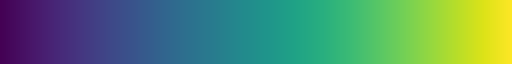

In [22]:
# Display the Viridis colormap used for the side-by-side maps
print(f"Color scale: Viridis_20 (EVI range: {vmin:.3f} to {vmax:.3f})")
print("Low EVI (purple) → High EVI (yellow)")
Viridis_20.mpl_colormap

In [23]:
# Adjust opacity/coverage on side-by-side maps without reloading the layers
early_layer.opacity = 0.3
early_layer.coverage = 0.95
recent_layer.opacity = 0.3
recent_layer.coverage = 0.95

## Distribution Comparison Charts

Static charts comparing EVI distributions between the two time periods. These complement the maps by showing the overall shift in vegetation health.

**Note:** This analysis compares Landsat 5 (1990s) with Landsat 8/9 (2020s). While both use Collection 2 surface reflectance products, minor sensor and calibration differences may contribute to observed changes.

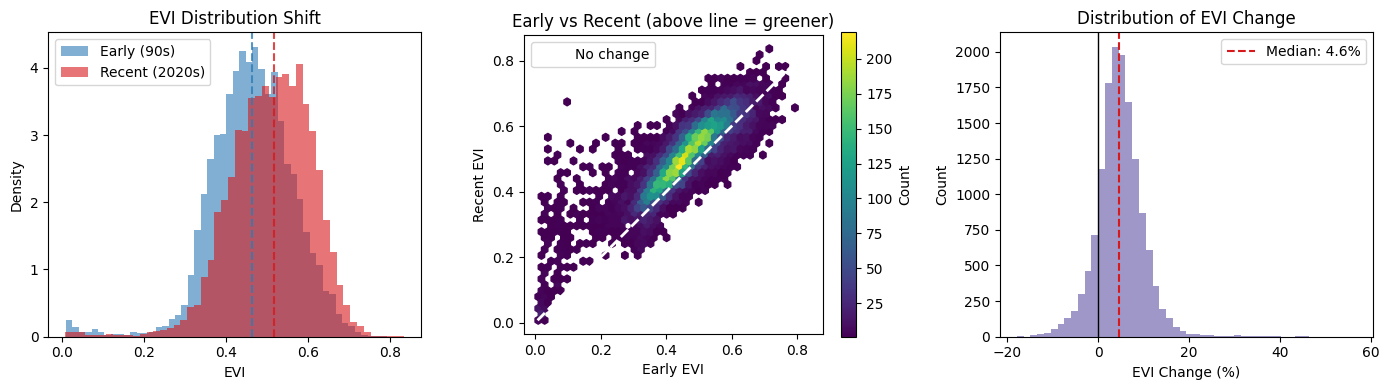

Median change: 4.63%
Hexagons with increase: 12,290 (86.2%)
Hexagons with decrease: 1,968 (13.8%)


In [24]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# 1. Overlapping histograms: Early vs Recent EVI distributions
ax1 = axes[0]
bins = 50
ax1.hist(df['early_avg'], bins=bins, alpha=0.6, label='Early (90s)', color='#2c7bb6', density=True)
ax1.hist(df['current_avg'], bins=bins, alpha=0.6, label='Recent (2020s)', color='#d7191c', density=True)
ax1.set_xlabel('EVI')
ax1.set_ylabel('Density')
ax1.set_title('EVI Distribution Shift')
ax1.legend()
ax1.axvline(df['early_avg'].median(), color='#2c7bb6', linestyle='--', alpha=0.8)
ax1.axvline(df['current_avg'].median(), color='#d7191c', linestyle='--', alpha=0.8)

# 2. Hexbin: Early vs Recent (points above diagonal = increase)
ax2 = axes[1]
hb = ax2.hexbin(df['early_avg'], df['current_avg'], gridsize=40, cmap='viridis', mincnt=1)
lims = [min(df['early_avg'].min(), df['current_avg'].min()),
        max(df['early_avg'].max(), df['current_avg'].max())]
ax2.plot(lims, lims, 'w--', linewidth=2, label='No change')
ax2.set_xlabel('Early EVI')
ax2.set_ylabel('Recent EVI')
ax2.set_title('Early vs Recent (above line = greener)')
ax2.set_aspect('equal')
ax2.legend()
plt.colorbar(hb, ax=ax2, label='Count')

# 3. Change distribution histogram
ax3 = axes[2]
ax3.hist(df['pct_change_evi'], bins=50, alpha=0.7, color='#756bb1')
ax3.axvline(0, color='black', linestyle='-', linewidth=1)
ax3.axvline(df['pct_change_evi'].median(), color='#d7191c', linestyle='--', label=f"Median: {df['pct_change_evi'].median():.1f}%")
ax3.set_xlabel('EVI Change (%)')
ax3.set_ylabel('Count')
ax3.set_title('Distribution of EVI Change')
ax3.legend()

plt.tight_layout()
plt.show()

# Summary stats
print(f"Median change: {df['pct_change_evi'].median():.2f}%")
print(f"Hexagons with increase: {(df['pct_change_evi'] > 0).sum():,} ({(df['pct_change_evi'] > 0).mean()*100:.1f}%)")
print(f"Hexagons with decrease: {(df['pct_change_evi'] < 0).sum():,} ({(df['pct_change_evi'] < 0).mean()*100:.1f}%)")

## EVI Percent Change Map: Vegetation Recovery and Decline

This map shows the **percent change in EVI** between the early period (1990s) and recent period (2020s), revealing where vegetation has increased or decreased over ~30 years.

**How to read this map:**
- **Color scale**: Roma diverging colormap (from palettable.scientific.diverging)
  - **Brown/Orange tones**: Vegetation decline (negative EVI change)
  - **White/Cream**: Little to no change (near 0%)
  - **Blue/Teal tones**: Vegetation increase (positive EVI change)
- **Red boundary**: Chernobyl Exclusion Zone (from OpenStreetMap via quackosm + Geofabrik)
- **Normalization**: Uses `TwoSlopeNorm` centered at 0, with bounds at 5th and 95th percentiles to handle outliers

**What the Chernobyl data shows:**
- The Exclusion Zone has experienced significant **vegetation regrowth** since human evacuation
- Abandoned agricultural fields, villages, and industrial areas have been reclaimed by forest
- This "rewilding" is visible as widespread positive EVI change (blue/teal hexagons)
- Some areas show decline, potentially due to natural forest dynamics, fire, or ongoing contamination effects

**Context:**
- EVI change is expressed as percentage points (e.g., +10 means EVI increased from 0.3 to 0.4)
- Positive values indicate greening; negative values indicate browning
- This is a relative measure comparing the same location across time

In [25]:
# Percent change map with filter controls
CHANGE_OPACITY = 0.6
CHANGE_COVERAGE = 0.95

change_norm = TwoSlopeNorm(
    vmin=df['pct_change_evi'].quantile(0.05), 
    vcenter=0, 
    vmax=df['pct_change_evi'].quantile(0.95)
)

# Pre-compute filtered dataframes
df_positive = df[df['pct_change_evi'] > 0]
df_negative = df[df['pct_change_evi'] < 0]

# Create three separate layers
def make_change_layer(data, visible=True):
    colors = apply_continuous_cmap(change_norm(data['pct_change_evi']), Roma_20, alpha=1)
    layer = H3HexagonLayer.from_pandas(
        data, get_hexagon=data["hex"],
        get_fill_color=colors,
        extruded=False,
        high_precision=True,
        stroked=False,
        auto_highlight=False,
        opacity=CHANGE_OPACITY,
        coverage=CHANGE_COVERAGE,
    )
    layer.visible = visible
    return layer

layer_all = make_change_layer(df, visible=True)
layer_positive = make_change_layer(df_positive, visible=False)
layer_negative = make_change_layer(df_negative, visible=False)

change_layers = {'all': layer_all, 'positive': layer_positive, 'negative': layer_negative}

# Build map with all three layers
def make_change_map_layers():
    layers = []
    if MAPBOX_TOKEN:
        basemap = BitmapTileLayer(
            data=f"https://api.mapbox.com/styles/v1/mapbox/satellite-streets-v12/tiles/512/{{z}}/{{x}}/{{y}}@2x?access_token={MAPBOX_TOKEN}",
            tile_size=512,
        )
        layers.append(basemap)
    layers.extend([layer_all, layer_positive, layer_negative])
    layers.append(zone_layer)
    return layers

change_map = Map(layers=make_change_map_layers(), view_state=initial_view)

# H3 layer toggle (toggles all three)
change_h3_toggle = widgets.ToggleButton(value=True, description='H3 Layer', icon='eye')
current_filter = 'all'

def on_change_h3_toggle(change):
    global current_filter
    for key, layer in change_layers.items():
        if key == current_filter:
            layer.visible = change['new']
        else:
            layer.visible = False
    change_h3_toggle.icon = 'eye' if change['new'] else 'eye-slash'

change_h3_toggle.observe(on_change_h3_toggle, names='value')

# Filter dropdown
change_filter = widgets.Dropdown(
    options=[('All', 'all'), ('EVI increase', 'positive'), ('EVI decrease', 'negative')],
    value='all',
    description='Filter:',
)

def on_filter_change(change):
    global current_filter
    current_filter = change['new']
    h3_visible = change_h3_toggle.value
    for key, layer in change_layers.items():
        layer.visible = (key == current_filter) and h3_visible

change_filter.observe(on_filter_change, names='value')

# Layout: controls above map
controls = widgets.HBox([change_h3_toggle, change_filter])
widgets.VBox([controls, change_map])
# Try changing the filter and toggling the H3 layer visibility


Color scale: Roma_20 (EVI change range: -3.4% to 12.8%, centered at 0%)
Decline (brown/orange) ← 0% (little change) → Increase (blue/teal)


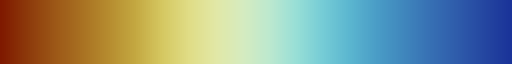

In [26]:
# Display the Roma diverging colormap used for the change map
change_vmin = df['pct_change_evi'].quantile(0.05)
change_vmax = df['pct_change_evi'].quantile(0.95)
print(f"Color scale: Roma_20 (EVI change range: {change_vmin:.1f}% to {change_vmax:.1f}%, centered at 0%)")
print("Decline (brown/orange) ← 0% (little change) → Increase (blue/teal)")
Roma_20.mpl_colormap

In [27]:
# Adjust opacity/coverage on change map (mutates in place)
change_opacity = 0.27
change_h3_coverage = 0.88

# Apply to all change layers
for layer in change_layers.values():
    layer.opacity = change_opacity
    layer.coverage = change_h3_coverage

